# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: 
бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Первая задача  — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# **Описание данных**

**id** — уникальный идентификатор сотрудника;

**dept** — отдел, в котором работает сотрудник;

**level** — уровень занимаемой должности;

**workload** — уровень загруженности сотрудника;

**employment_years** — длительность работы в компании (в годах);

**last_year_promo** — показывает, было ли повышение за последний год;

**last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;

**supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;

**salary** — ежемесячная зарплата сотрудника;

**job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install --upgrade scikit-learn joblib -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, roc_auc_score
from sklearn.dummy import DummyRegressor, DummyClassifier

from phik import phik_matrix
from phik.binning import bin_data
from joblib import parallel_backend

In [5]:
try:
    train = pd.read_csv('train_job_satisfaction_rate.csv')
    test_feat = pd.read_csv('test_features.csv')
    test_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_feat = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [6]:
test_feat = test_feat.sort_values(by='id')
test_target = test_target.sort_values(by='id')

## Задача : предсказание уровня удовлетворённости сотрудника

In [7]:
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Заменим строки, содержащие только пробелы, на NaN

In [9]:
train.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [10]:
print("Пропуски в тренировочном наборе:")
print(train.isnull().sum())

Пропуски в тренировочном наборе:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [11]:
print("Уникальные значения:")
u_v_train = train[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_train)

Уникальные значения:


dept                    [sales, hr, technology, purchasing, marketing,...
level                                       [junior, middle, sinior, nan]
workload                                              [medium, high, low]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

В столбце "level", sinior это ошибка, должно быть senior, заменим. 

In [12]:
train['level'] = train['level'].replace('sinior', 'senior')

In [13]:
print("Проверим уникальные значения после изменения:")
u_v_train = train[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_train)

Проверим уникальные значения после изменения:


dept                    [sales, hr, technology, purchasing, marketing,...
level                                       [junior, middle, senior, nan]
workload                                              [medium, high, low]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

In [14]:
train.dept.value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [15]:
train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Данные тренеровчоной выборки выглядят нормально

In [16]:
test_feat.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [17]:
test_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [18]:
test_feat.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [19]:
print("\nПропуски в тестовом наборе:")
print(test_feat.isnull().sum())


Пропуски в тестовом наборе:
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [20]:
print("Уникальные значения:")
u_v_test_feat = test_feat[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_test_feat)

Уникальные значения:


dept                    [hr, marketing, purchasing, sales, technology,...
level                                       [junior, middle, sinior, nan]
workload                                         [low, high, medium, nan]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

In [21]:
test_feat['level'] = test_feat['level'].replace('sinior', 'senior')

In [22]:
print("Проверим уникальные значения после изменения:")
u_v_test_feat = test_feat[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_test_feat)

Проверим уникальные значения после изменения:


dept                    [hr, marketing, purchasing, sales, technology,...
level                                       [junior, middle, senior, nan]
workload                                         [low, high, medium, nan]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

In [23]:
test_feat.dept.value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

In [24]:
test_feat.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Данные тестовой выборки выглядят нормально

In [25]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1734 to 334
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


In [26]:
test_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Данные тестовой целевой выборки выглядят нормально

### Исследовательский анализ данных

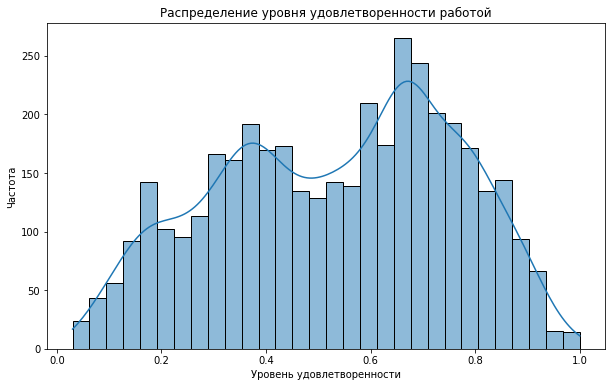

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(train['job_satisfaction_rate'], bins=30, kde=True)
plt.title('Распределение уровня удовлетворенности работой')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Частота')
plt.show()

Распределение уровня удовлетворенности работой:

Бимодальное распределение: График показывает два выраженных пика, один около значения 0.3–0.4, а другой около значения 0.6–0.7.

Это указывает на то, что существуют две группы сотрудников с разными уровнями удовлетворенности:

Одна группа сотрудников имеет относительно низкий уровень удовлетворенности.
Другая группа показывает средний уровень удовлетворенности.
Слабый хвост на высокой удовлетворенности: Меньшее количество сотрудников демонстрируют высокий уровень удовлетворенности (0.8–1.0). Это может указывать на то, что в компании есть незначительное количество сотрудников, которые полностью довольны своей работой.

#### Выводы:

Существуют две значительные группы сотрудников с разными уровнями удовлетворенности. Это может свидетельствовать о различиях в условиях работы, подходах управления или мотивации в разных частях компании.
Рекомендуется провести более глубокий анализ, чтобы выявить конкретные факторы, влияющие на удовлетворенность в каждой из этих групп.

In [28]:
train_copy = train.copy()

# Порядок для 'level' и 'workload'
level_order = ['junior', 'middle', 'senior']
workload_order = ['low', 'medium', 'high']

train_copy['level'] = pd.Categorical(train_copy['level'], categories=level_order, ordered=True)
train_copy['workload'] = pd.Categorical(train_copy['workload'], categories=workload_order, ordered=True)

# Построение матрицы корреляции с учетом упорядоченных признаков
phik_matrix = train_copy.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

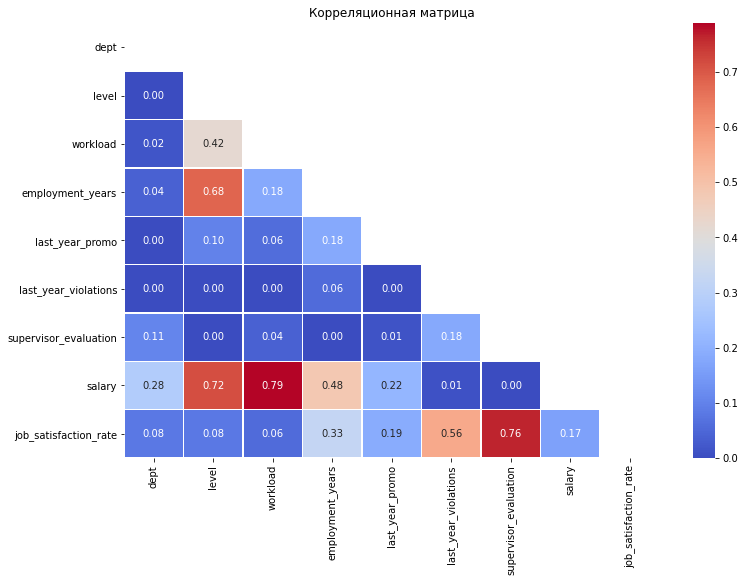

In [29]:
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

#### Выводы:

**supervisor_evaluation:** Имеет положительную корреляцию с уровнем удовлетворенности работой (0.76). Это высокая корреляция, указывающая на то, что положительные отзывы руководства сильно способствуют росту удовлетворенности сотрудников.

**employment_years:** Корреляция с удовлетворенностью работой составляет 0.33. Это умеренная корреляция, указывающая на то, что с увеличением стажа работы в компании уровень удовлетворенности сотрудников может возрастать, но связь не является очень сильной.

**salary:** Корреляция с уровнем удовлетворенности составляет 0.17, что указывает на слабую положительную связь. Это означает, что более высокая зарплата может способствовать повышению удовлетворенности работой, хотя, возможно, это не является ключевым фактором.

**workload:** Корреляция с удовлетворенностью составляет 0.19, что указывает на слабую положительную связь. Это может свидетельствовать о том, что сотрудники с более высокой загрузкой могут испытывать чуть большее удовлетворение от своей работы, возможно, из-за чувства выполненного долга или признания за свои усилия.

**employment_years и salary:** Эти два признака имеют высокую корреляцию (0.79), что говорит о сильной связи между длительностью работы в компании и уровнем зарплаты. Это логично, так как более длительный стаж обычно приводит к повышению заработной платы.

**workload и employment_years:** Корреляция между ними составляет 0.66, что указывает на значительную связь. Это может означать, что сотрудники, работающие дольше, могут иметь большую загрузку, что также связано с их опытом и ответственностью.

**level и employment_years:** Корреляция составляет 0.66, что указывает на значительную связь. Это подтверждает предположение, что более высокий уровень должности обычно достигается после нескольких лет работы в компании.

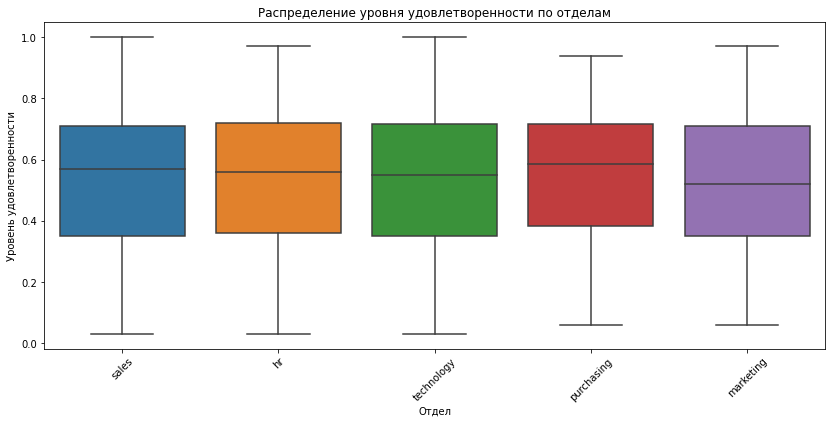

In [30]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='dept', y='job_satisfaction_rate', data=train)
plt.title('Распределение уровня удовлетворенности по отделам')
plt.xlabel('Отдел')
plt.ylabel('Уровень удовлетворенности')
plt.xticks(rotation=45)
plt.show()

#### Выводы:

- В большинстве отделов медианные значения уровня удовлетворенности находятся примерно на одном уровне (около 0.5-0.6). Это указывает на то, что, независимо от отдела, базовая удовлетворенность сотрудников схожа.
- В некоторых отделах, таких как hr и technology, диапазон удовлетворенности шире, чем в других. Это может свидетельствовать о более разнообразном опыте работы или условиях в этих отделах.

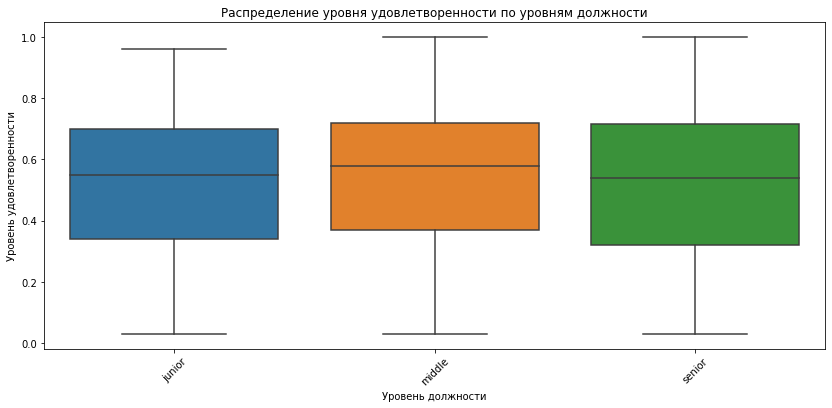

In [31]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='level', y='job_satisfaction_rate', data=train)
plt.title('Распределение уровня удовлетворенности по уровням должности')
plt.xlabel('Уровень должности')
plt.ylabel('Уровень удовлетворенности')
plt.xticks(rotation=45)
plt.show()

**Junior vs Senior:** На графике видно, что уровень удовлетворенности среди сотрудников уровня junior ниже, чем у middle и senior. Это может быть связано с тем, что сотрудники на начальных уровнях должности могут сталкиваться с большими вызовами или ограниченными возможностями.

**Senior и Middle:** Сотрудники на уровнях senior и middle имеют более высокие и схожие уровни удовлетворенности, что может указывать на то, что эти позиции предлагают более удовлетворительные условия работы.

#### Выводы:

**Общие уровни удовлетворенности:** Удовлетворенность в различных отделах и уровнях должности имеет различия, но большинство категорий имеют медианные значения в пределах 0.5-0.6, что указывает на умеренную удовлетворенность сотрудников.

**Влияние уровня должности:** Уровень должности играет роль в удовлетворенности, причем сотрудники с более высоким уровнем должности, как правило, более удовлетворены. Это может быть связано с лучшими условиями работы, большей автономией и другими преимуществами старших позиций.

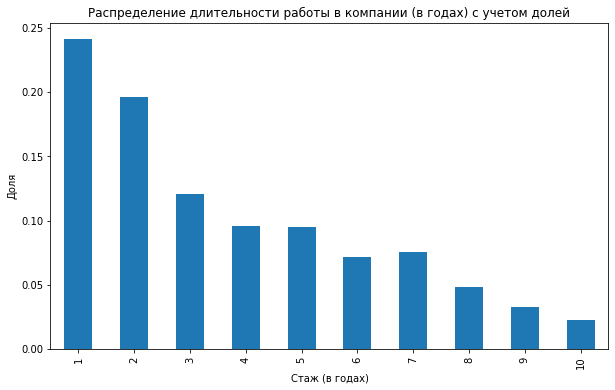

In [32]:
# Подсчет долей для каждого значения employment_years
employment_years_counts = train['employment_years'].value_counts(normalize=True)

# Визуализация распределения длительности работы с учетом долей
plt.figure(figsize=(10, 6))
employment_years_counts.sort_index().plot(kind='bar')
plt.title('Распределение длительности работы в компании (в годах) с учетом долей')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля')
plt.show()

In [33]:
display(employment_years_counts)

1     0.24150
2     0.19625
3     0.12075
4     0.09600
5     0.09500
7     0.07525
6     0.07175
8     0.04825
9     0.03250
10    0.02275
Name: employment_years, dtype: float64

#### Выводы:

Большой пик на 1 год всё ещё указывает на высокую текучесть кадров, где многие сотрудники покидают компанию после первого года работы. Это может свидетельствовать о том, что компания сталкивается с проблемами удержания сотрудников на ранних этапах их карьеры.

Группы сотрудников с длительным стажем (5 лет и более) значительно меньше, что может указывать на более стабильную, но малочисленную группу лояльных сотрудников. Однако, начиная с 6 лет стажа, виден некоторый рост, что может говорить о том, что те, кто остаются в компании достаточно долго, с большей вероятностью продолжают работать длительное время.

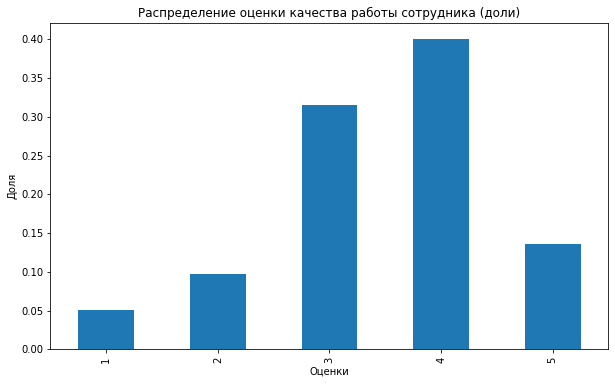

In [34]:
# Подсчет долей для каждого значения supervisor_evaluation
supervisor_evaluation_counts = train['supervisor_evaluation'].value_counts(normalize=True)

# Визуализация распределения оценки качества работы с учетом долей
plt.figure(figsize=(10, 6))
supervisor_evaluation_counts.sort_index().plot(kind='bar')
plt.title('Распределение оценки качества работы сотрудника (доли)')
plt.xlabel('Оценки')
plt.ylabel('Доля')
plt.show()

In [35]:
display(supervisor_evaluation_counts)

4    0.40075
3    0.31575
5    0.13650
2    0.09675
1    0.05025
Name: supervisor_evaluation, dtype: float64

#### Выводы:

1) Наиболее распространенная оценка — 4:

Комментарий: Самый высокий столбец на графике соответствует оценке 4. Это указывает на то, что большинство сотрудников получают высокие оценки от своих руководителей, что может отражать общее удовлетворение качеством их работы. Эта оценка, вероятно, является стандартом, используемым для сотрудников, которые выполняют свои обязанности на высоком уровне.

2) Оценка 3 — также частое явление:

Комментарий: Оценка 3 также часто встречается, что может говорить о том, что значительная часть сотрудников выполняет свои обязанности на среднем уровне. Это может свидетельствовать о том, что руководство склонно использовать средние оценки, возможно, для сотрудников, чья работа соответствует ожиданиям, но не выделяется.
Редкие крайние оценки (1 и 5):

3) Оценки 1 и 5 встречаются реже. 

Низкие оценки (1) применяются крайне редко, что может означать, что руководители стараются избегать самых низких оценок, вероятно, чтобы не демотивировать сотрудников. Высокие оценки (5), хотя и не такие редкие, как 1, также используются с осторожностью, что может указывать на высокие требования для получения самой высокой оценки.

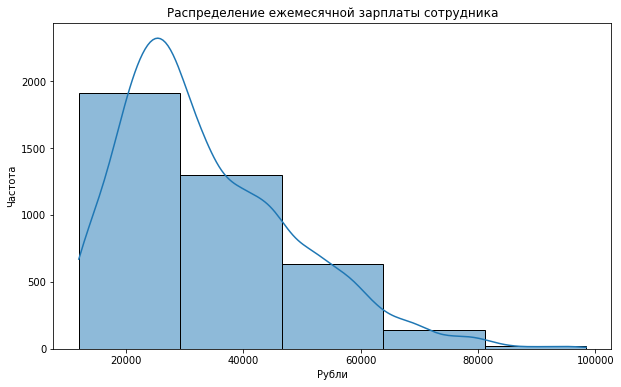

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(train['salary'], bins=5, kde=True)
plt.title('Распределение ежемесячной зарплаты сотрудника')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show() 

#### Выводы:
График показывает, что зарплаты сотрудников в компании имеют правостороннее (положительно скошенное) распределение. Большинство сотрудников получают зарплату в пределах 20,000-40,000 рублей.

Компания имеет значительное количество сотрудников с относительно низким уровнем зарплат, и лишь немногие сотрудники получают высокие зарплаты (более 60,000 рублей).

In [37]:
categorical_columns = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загрузка',
    'last_year_promo': 'Повышение в прошлом году',
    'last_year_violations': 'Нарушения в прошлом году'
}

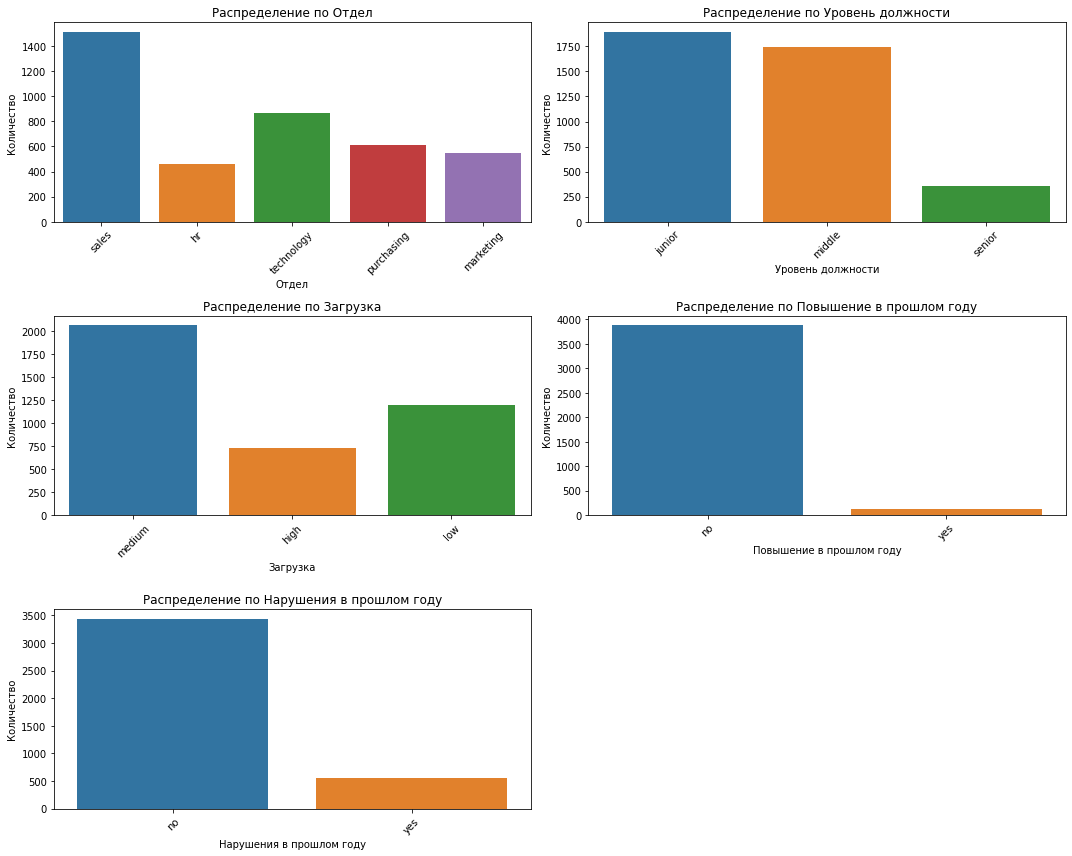

In [38]:
plt.figure(figsize=(15, 12))
for i, (column, label) in enumerate(categorical_columns.items(), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train, x=column)
    plt.title(f'Распределение по {label}')
    plt.xlabel(label)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Выводы:

1) Распределение по Отделам (dept):

- На графике видно, что большинство сотрудников работают в отделе продаж (sales), за ним следует отдел технологии (technology). Отделы HR и маркетинга представлены наименее.
- Отдел продаж является доминирующим в компании, что может свидетельствовать о важности этого отдела для бизнеса. Возможно, основное внимание компании сосредоточено на увеличении продаж, что требует большого количества персонала.

2) Распределение по Уровню должности (level):

- В компании преобладают сотрудники уровня junior и middle, тогда как сотрудников уровня senior значительно меньше.
- Компания, вероятно, нанимает много молодых специалистов (junior и middle), что может говорить о стремлении развивать и обучать персонал внутри компании. Небольшое количество сотрудников уровня senior может свидетельствовать либо о высокой текучести кадров на высоких позициях, либо о редком продвижении на эти должности.

3) Распределение по Загрузке (workload):

- Большинство сотрудников имеют среднюю (medium) загрузку, значительное количество имеют низкую (low) и высокую (high) загрузку, но они реже встречаются.
- Средняя загрузка является нормой для большинства сотрудников. В зависимости от потребностей компании и задач, перераспределение нагрузки может улучшить эффективность работы, особенно если есть тенденция к перегрузке или недозагрузке отдельных сотрудников.

4) Распределение по Повышению в прошлом году (last_year_promo):

- Подавляющее большинство сотрудников не получали повышения в прошлом году (значение "no"), а только небольшая часть была повышена (значение "yes").
- Низкая частота повышений может указывать на строгие критерии для повышения или на медленный карьерный рост в компании. Это может повлиять на мотивацию сотрудников и их удовлетворенность работой.

5) Распределение по Нарушениям в прошлом году (last_year_violations):

- Большинство сотрудников не имели нарушений в прошлом году (значение "no"), и лишь небольшая часть совершила нарушения (значение "yes").
- Высокий уровень дисциплины среди сотрудников, вероятно, способствует поддержанию положительного рабочего климата и продуктивности. Это также может говорить о строгих правилах и эффективной системе контроля в компании.

# Расмотрим  **test_feat**

In [39]:
test_feat_copy = test_feat.copy()
level_order = ['junior', 'middle', 'senior']

test_feat_copy['level'] = pd.Categorical(test_feat_copy['level'], categories=level_order, ordered=True)
phik_matrix = test_feat_copy.drop('id', axis=1).phik_matrix(interval_cols=['salary'])

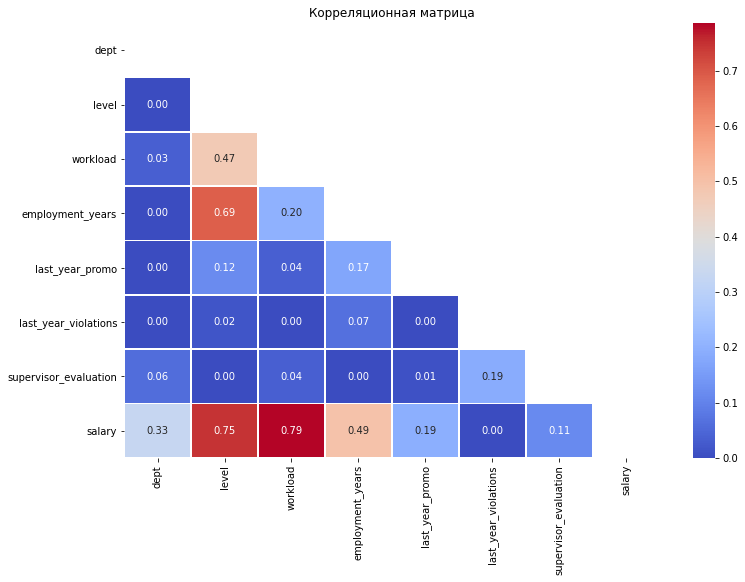

In [40]:
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

#### Выводы:

1) Уровень должности (level) и Зарплата (salary):

- Высокая положительная корреляция (0.60) между уровнем должности и зарплатой указывает на то, что по мере повышения уровня должности (от junior к senior) значительно увеличивается зарплата.
- Уровень должности является важным фактором при определении зарплаты. 

2) Загрузка (workload) и Зарплата (salary):

- Очень высокая корреляция (0.79) между загрузкой и зарплатой. Это означает, что сотрудники с большей загрузкой, как правило, получают более высокую зарплату.
- Загрузка сотрудников тесно связана с их заработной платой, возможно, в зависимости от того, что более загруженные сотрудники берут на себя больше обязанностей или выполняют более сложные задачи, что приводит к повышению их заработной платы.

3) Стаж (employment_years) и Зарплата (salary):

- Стаж работы в компании также сильно коррелирует с зарплатой (0.49). Это указывает на то, что сотрудники, работающие дольше, как правило, получают более высокую оплату.
- Стаж работы имеет значительное влияние на уровень заработной платы, что обычно связано с накоплением опыта и, возможно, с продвижением по службе в течение времени.

4) Уровень должности (level) и Загрузка (workload):

- Сильная положительная корреляция (0.44) между уровнем должности и загрузкой показывает, что более высокие должности часто связаны с большей рабочей нагрузкой.
- Сотрудники на более высоких должностях могут брать на себя больше ответственности, что ведет к увеличению рабочей нагрузки. 

5)Стаж (employment_years) и Уровень должности (level):

- Значительная корреляция (0.67) между стажем и уровнем должности свидетельствует о том, что сотрудники с большим стажем, как правило, занимают более высокие должности.
- Продолжительный стаж работы способствует продвижению по службе. Это ожидаемо, поскольку сотрудники, работающие дольше, имеют больше шансов на повышение.

6) Оценка работы руководителем (supervisor_evaluation) и Удовлетворенность работой:

- Небольшая положительная корреляция (0.19) между оценкой работы и удовлетворенностью может указывать на слабую связь между тем, как сотрудники оцениваются и их собственным восприятием удовлетворенности работой.
- Несмотря на то, что оценка работы руководителем оказывает некоторое влияние на удовлетворенность работой, эта связь не является значительной, что может свидетельствовать о наличии других факторов, влияющих на удовлетворенность сотрудников.

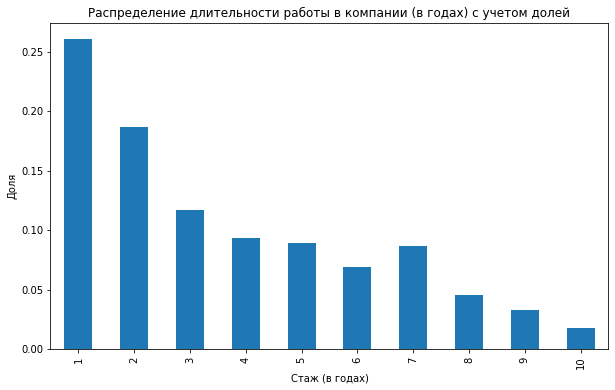

Доли длительности работы в компании (в годах):
1     0.2610
2     0.1870
3     0.1170
4     0.0935
5     0.0895
6     0.0690
7     0.0870
8     0.0455
9     0.0330
10    0.0175
Name: employment_years, dtype: float64


In [41]:
# Подсчет долей для каждого значения employment_years
employment_years_counts = test_feat['employment_years'].value_counts(normalize=True)

# Визуализация распределения длительности работы с учетом долей
plt.figure(figsize=(10, 6))
employment_years_counts.sort_index().plot(kind='bar')
plt.title('Распределение длительности работы в компании (в годах) с учетом долей')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля')
plt.show()

# Вывод долей в консоль
print("Доли длительности работы в компании (в годах):")
print(employment_years_counts.sort_index())

#### Выводы:
Распределение длительности работы сотрудников в тестовой выборке (test_feat) аналогично тренировочной выборке (train). В обеих выборках наблюдается пик на уровне 1 года стажа и плавным снижением по мере увеличения стажа.

Распределение признака "employment_years" в тестовой выборке соответствует тренировочной, что подтверждает корректность разделения данных и говорит о том, что выявленные ранее закономерности будут также справедливы и для тестовой выборки. Это гарантирует, что модель будет оценена на тестовых данных корректно.

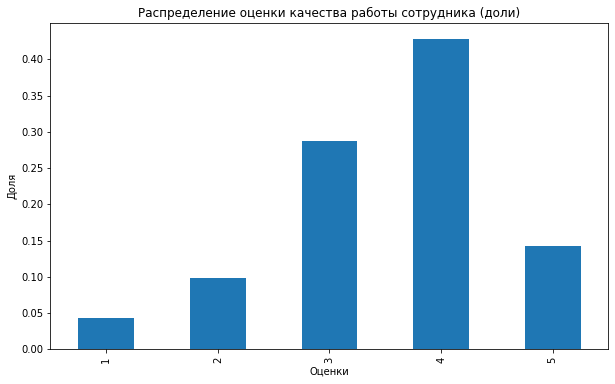

Доли оценки качества работы сотрудника:
1    0.0440
2    0.0980
3    0.2875
4    0.4285
5    0.1420
Name: supervisor_evaluation, dtype: float64


In [42]:
# Подсчет долей для каждого значения supervisor_evaluation
supervisor_evaluation_counts = test_feat['supervisor_evaluation'].value_counts(normalize=True)

# Визуализация распределения оценки качества работы с учетом долей
plt.figure(figsize=(10, 6))
supervisor_evaluation_counts.sort_index().plot(kind='bar')
plt.title('Распределение оценки качества работы сотрудника (доли)')
plt.xlabel('Оценки')
plt.ylabel('Доля')
plt.show()

# Вывод долей в консоль
print("Доли оценки качества работы сотрудника:")
print(supervisor_evaluation_counts.sort_index())

#### Выводы:
Распределение оценок качества работы сотрудников, данных их руководителями, в тестовой выборке аналогично распределению в тренировочной выборке. 

В обоих наборах данных преобладают средние и высокие оценки, с пиками на уровне 3 и 4 баллов.

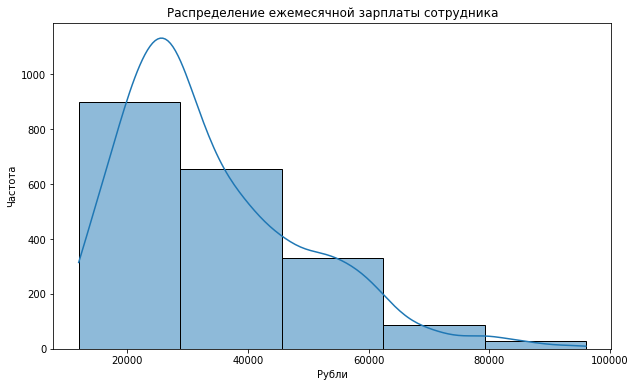

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(test_feat['salary'], bins=5, kde=True)
plt.title('Распределение ежемесячной зарплаты сотрудника')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show() 

#### Выводы:
Распределение ежемесячной зарплаты сотрудников в тестовой выборке  показывает аналогичные характеристики с тренировочной выборкой. В обоих случаях наблюдается правостороннее (положительно скошенное) распределение, где большая часть сотрудников получает зарплату в диапазоне от 20,000 до 40,000 рублей, с постепенным уменьшением количества сотрудников по мере увеличения зарплаты.

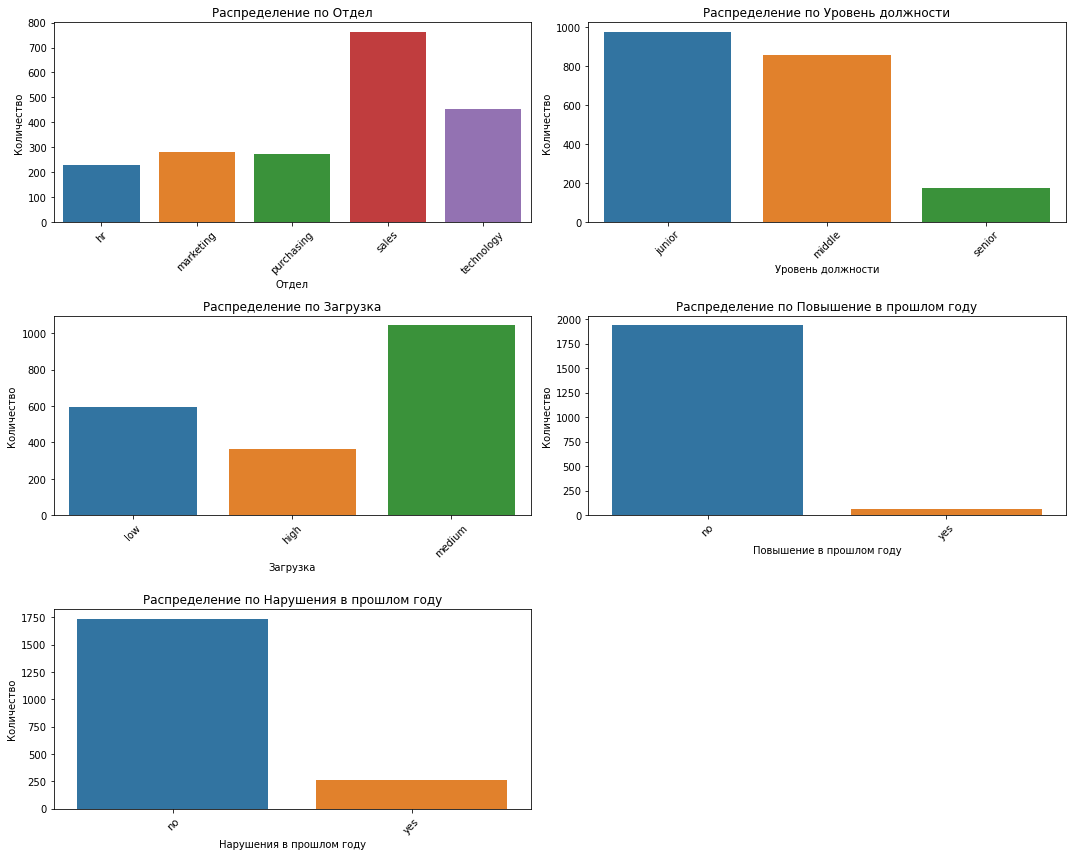

In [44]:
plt.figure(figsize=(15, 12))
for i, (column, label) in enumerate(categorical_columns.items(), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=test_feat, x=column)
    plt.title(f'Распределение по {label}')
    plt.xlabel(label)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Выводы: 
Распределение категориальных признаков в тестовой выборке (test_feat) схоже с распределением в тренировочной выборке (train). Все ключевые закономерности, которые наблюдались в тренировочных данных, сохраняются в тестовых данных.

## Подготовка и предобработка данных

In [45]:
# Сортировка по 'id'спустя три часа и кучу испорченных метрик, я понял что данные размешаны. 
train = train.sort_values(by='id')
test_feat = test_feat.sort_values(by='id')
test_target = test_target.sort_values(by='id')

In [46]:
# Разделение 
X_train = train.drop(columns=['job_satisfaction_rate', 'id'])
y_train = train['job_satisfaction_rate']

In [47]:
# Подготовка тестовой выборки
X_test = test_feat.drop(columns=['id'])
y_test = test_target['job_satisfaction_rate'] 

In [48]:
# Обработка категориальных признаков
categorical_nominal_features = ['dept', 'last_year_promo', 'last_year_violations']
categorical_ordinal_features = ['level', 'workload'] 

In [49]:
# Масштабирование числовых признаков
numerical_features = ['employment_years', 'supervisor_evaluation', 'salary']

In [50]:
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [51]:
numerical_imputer = SimpleImputer(strategy='mean')

In [52]:
# Создание трансформеров
categorical_nominal_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),  
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))  
])

In [53]:
categorical_ordinal_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),  
    ('encoder', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], 
                                           ['low', 'medium', 'high']]))  
])

numerical_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer), 
    ('scaler', StandardScaler())  
])

In [54]:
# Создание ColumnTransformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_nom', categorical_nominal_transformer, categorical_nominal_features),
        ('cat_ord', categorical_ordinal_transformer, categorical_ordinal_features)
    ])

In [55]:
# Определяем функцию SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

# Создаем объект make_scorer для SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

In [56]:
# Создание пайплайна
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())  
])

In [57]:
param_grid = [
    {
        'model': [Ridge()],  
        'model__alpha': [0.1, 1.0, 10.0]  
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)],  
        'model__max_depth': [5, 7, 10, 13],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
]


In [58]:
# Выполнение кросс-валидации и подбор гиперпараметров для обеих моделей
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(X_train, y_train)

# Получение результатов кросс-валидации для всех моделей
cv_results = pd.DataFrame(grid_search.cv_results_)

# Отображение метрик для всех исследованных моделей
results_to_display = cv_results[['params', 'mean_test_score', 'std_test_score']]
results_to_display = results_to_display.sort_values(by='mean_test_score', ascending=False)

# Печать результатов
print("Метрики всех исследованных моделей на кросс-валидации:")
display(results_to_display)

Метрики всех исследованных моделей на кросс-валидации:


,params,mean_test_score,std_test_score
37,{'model': DecisionTreeRegressor(random_state=4...,-14.753387,0.762860
36,{'model': DecisionTreeRegressor(random_state=4...,-14.753387,0.762860
34,{'model': DecisionTreeRegressor(random_state=4...,-14.789066,0.420507
33,{'model': DecisionTreeRegressor(random_state=4...,-14.795019,0.412756
38,{'model': DecisionTreeRegressor(random_state=4...,-14.826546,0.671214
35,{'model': DecisionTreeRegressor(random_state=4...,-14.921593,0.426308
31,{'model': DecisionTreeRegressor(random_state=4...,-14.995696,0.442567
32,{'model': DecisionTreeRegressor(random_state=4...,-15.011149,0.455721
30,{'model': DecisionTreeRegressor(random_state=4...,-15.338459,0.642177
28,{'model': DecisionTreeRegressor(random_state=4...,-15.414643,0.744062


In [59]:
# Лучшая модель и её SMAPE
best_pipeline = grid_search.best_estimator_
y_pred_best = best_pipeline.predict(X_test)
best_smape = smape(y_test, y_pred_best)

print(f"Лучшая модель после подбора гиперпараметров: {best_pipeline}")
print(f"Лучший SMAPE: {best_smape:.2f}")

Лучшая модель после подбора гиперпараметров: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary']),
                                                 ('cat_nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
 

Критерий успеха: SMAPE ≤ 15 на тестовой выборке. 

**ЭТО КРИТИЧЕСКИЙ УСПЕХ!**

In [60]:
print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшие параметры: {'model': DecisionTreeRegressor(random_state=42), 'model__max_depth': 13, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


In [61]:
# Проверка модели на адекватность с DummyRegressor
dummy_model = DummyRegressor(strategy="mean")
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Используем ту же предобработку
    ('model', dummy_model)
])

# Обучение DummyRegressor и предсказания
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)
dummy_smape = smape(y_test, y_pred_dummy)

print(f"SMAPE для DummyRegressor (предсказание среднего): {dummy_smape:.2f}")

# Сравнение результатов
if best_smape < dummy_smape:
    print("Лучшая модель превосходит DummyRegressor.")
else:
    print("Лучшая модель не превосходит DummyRegressor. Возможно, стоит пересмотреть подход.")

SMAPE для DummyRegressor (предсказание среднего): 38.22
Лучшая модель превосходит DummyRegressor.


### Результаты моделей:

1) Линейная модель Ridge справилась с задачей, но её SMAPE оказался выше, чем у модели на основе дерева решений.

2) После подбора гиперпараметров, Decision Tree достигло лучшего результата с SMAPE 13.66. Это означает, что дерево решений смогло точнее предсказать уровень удовлетворенности сотрудников по сравнению с линейной моделью.

Почему дерево решений оказалось лучше? 

- Нелинейные зависимости: 
Дерево решений способно улавливать нелинейные зависимости между признаками и целевым показателем. Учитывая, что уровень удовлетворенности сотрудников может зависеть от сложных взаимодействий между признаками, дерево решений лучше справляется с такими задачами.
- Гибкость модели: 
Decision Tree имеет большую гибкость в сравнении с линейными моделями, что позволяет ему лучше адаптироваться к сложным структурам данных.
- Подбор гиперпараметров: 
После применения GridSearchCV для поиска оптимальных значений гиперпараметров, модель дерева решений смогла настроиться на данные и показать более точные предсказания.


#### Заключение:

Decision Tree оказалось лучшей моделью для данной задачи, так как оно лучше справилось с предсказанием уровня удовлетворенности сотрудников. Это связано с его способностью обрабатывать нелинейные зависимости и лучше адаптироваться к структуре данных.

## Задача : предсказание увольнения сотрудника из компании

In [62]:
try:
    train_2 = pd.read_csv('train_quit.csv')
    test_feat_2 = pd.read_csv('test_features.csv')
    test_target_2 = pd.read_csv('test_target_quit.csv')
except:
    train_2 = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_feat_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [63]:
train_2 = train_2.sort_values(by='id')
test_feat_2 = test_feat_2.sort_values(by='id')
test_target_2 = test_target_2.sort_values(by='id')

In [64]:
train_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [65]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2600 to 2120
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


In [66]:
train_2.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [67]:
print("Пропуски в тренировочном наборе:")
print(train_2.isnull().sum())

Пропуски в тренировочном наборе:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [68]:
print("Уникальные значения:")
u_v_train_2 = train_2[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations', "quit"]].apply(pd.Series.unique)
display(u_v_train_2)


Уникальные значения:


dept                    [sales, purchasing, marketing, technology, hr]
level                                         [junior, middle, sinior]
workload                                           [medium, high, low]
last_year_promo                                              [no, yes]
last_year_violations                                         [no, yes]
quit                                                         [yes, no]
dtype: object

In [69]:
train_2['level'] = train_2['level'].replace('sinior', 'senior')

In [70]:

u_v_train_2 = train_2[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_test_feat)

dept                    [hr, marketing, purchasing, sales, technology,...
level                                       [junior, middle, senior, nan]
workload                                         [low, high, medium, nan]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

Данные в отличном состоянии, ничего менять тут не буду! 

In [71]:
test_feat_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [72]:
test_feat_2.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [73]:
test_feat_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [74]:
print("Пропуски в тренировочном наборе:")
print(test_feat_2.isnull().sum())

Пропуски в тренировочном наборе:
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [75]:
print("Уникальные значения:")
u_v_test_feat_2 = test_feat_2[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_test_feat_2)


Уникальные значения:


dept                    [hr, marketing, purchasing, sales, technology,...
level                                       [junior, middle, sinior, nan]
workload                                         [low, high, medium, nan]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

In [76]:
test_feat_2['level'] = test_feat_2['level'].replace('sinior', 'senior')

In [77]:
print("Уникальные значения:")
u_v_test_feat_2 = test_feat_2[["dept",'level', 'workload', 'last_year_promo', 'last_year_violations']].apply(pd.Series.unique)
display(u_v_test_feat_2)

Уникальные значения:


dept                    [hr, marketing, purchasing, sales, technology,...
level                                       [junior, middle, senior, nan]
workload                                         [low, high, medium, nan]
last_year_promo                                                 [no, yes]
last_year_violations                                            [no, yes]
dtype: object

In [78]:
test_feat_2.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [79]:
test_target_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [80]:
test_target_2.quit.value_counts()

no     1436
yes     564
Name: quit, dtype: int64

Удаляю пропущенные значения

### Исследовательский анализ данных

In [81]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2600 to 2120
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


In [82]:
train_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [83]:
train_copy_2 = train_2.copy()

# Порядок для 'level' и 'workload'
level_order = ['junior', 'middle', 'senior']
workload_order = ['low', 'medium', 'high']

train_copy_2['level'] = pd.Categorical(train_copy_2['level'], categories=level_order, ordered=True)
train_copy_2['workload'] = pd.Categorical(train_copy_2['workload'], categories=workload_order, ordered=True)

# Построение матрицы корреляции с учетом упорядоченных признаков
phik_matrix = train_copy_2.drop('id', axis=1).phik_matrix(interval_cols=['salary'])


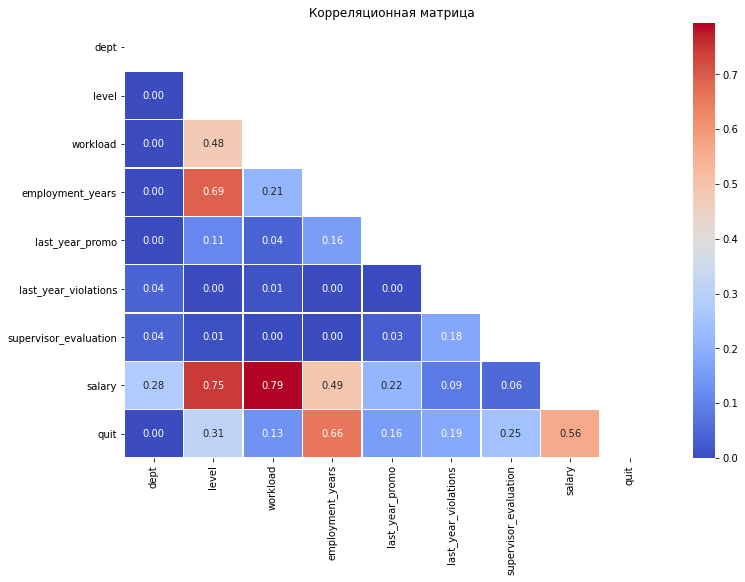

In [84]:
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

#### Выводы:
**supervisor_evaluation:** Имеет положительную корреляцию с уровнем удовлетворенности работой (job_satisfaction_rate) (0.18). Это указывает на слабую связь между оценкой, данной руководителем, и удовлетворенностью сотрудника. Хотя связь не является очень сильной, положительные отзывы руководства могут способствовать росту удовлетворенности сотрудников.

**employment_years:** Имеет значительную корреляцию с уровнем увольнения сотрудников (quit) (0.66). Это указывает на то, что чем дольше сотрудник работает в компании, тем выше вероятность его увольнения, что может быть связано с накоплением усталости или стремлением к изменениям после длительного периода работы.

**salary:** Корреляция с уровнем увольнения сотрудников (quit) составляет 0.56. Это указывает на то, что сотрудники с более высокой зарплатой менее склонны к увольнению, что логично, поскольку высокая оплата труда может служить мотивирующим фактором для оставления на рабочем месте.

**workload:** Корреляция с уровнем увольнения составляет 0.13, что указывает на слабую положительную связь. Это может свидетельствовать о том, что сотрудники с большей загрузкой могут испытывать небольшое увеличение желания уволиться, возможно, из-за стресса или чрезмерной нагрузки.

**employment_years и salary:** Эти два признака имеют высокую корреляцию (0.79), что говорит о сильной связи между длительностью работы в компании и уровнем зарплаты. Обычно более длительный стаж приводит к повышению заработной платы.

**workload и employment_years:** Корреляция между ними составляет 0.66, что указывает на значительную связь. Это может означать, что сотрудники, работающие дольше, имеют большую загрузку, что связано с их опытом и ответственностью.

**level и salary:** Корреляция составляет 0.61, что указывает на значительную связь. Это подтверждает предположение, что более высокий уровень должности обычно сопровождается более высокой зарплатой.

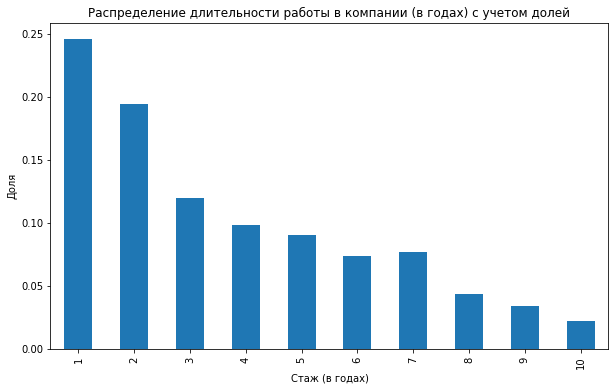

In [85]:
# Подсчет количества наблюдений для каждого значения employment_years
employment_years_counts = train_2['employment_years'].value_counts(normalize=True)

# Визуализация с помощью столбчатой диаграммы
plt.figure(figsize=(10, 6))
employment_years_counts.sort_index().plot(kind='bar')
plt.title('Распределение длительности работы в компании (в годах) с учетом долей')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля')
plt.show()

In [86]:
display(employment_years_counts)

1     0.24625
2     0.19425
3     0.11975
4     0.09825
5     0.09050
7     0.07700
6     0.07400
8     0.04350
9     0.03400
10    0.02250
Name: employment_years, dtype: float64

Большая часть сотрудников работает в компании менее двух лет. Доля сотрудников с увеличением стажа работы значительно уменьшается.

Основной "отток" новых сотрудников происходит на ранних этапах карьеры, что может указывать на проблемы с удержанием новых работников.

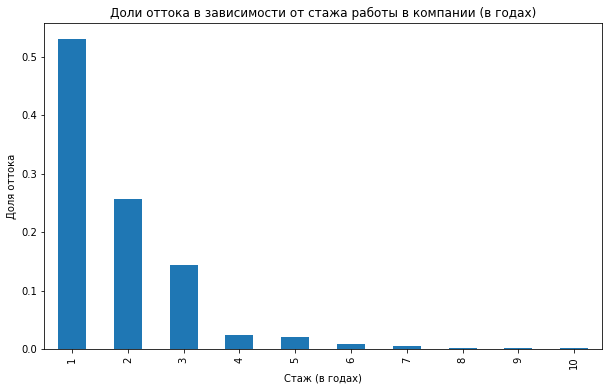

In [87]:
# Фильтрация данных для сотрудников, которые ушли из компании (quit == "yes")
churned = train_2[train_2['quit'] == 'yes']

# Подсчет долей оттока для каждого значения employment_years
employment_years_churned_counts = churned['employment_years'].value_counts(normalize=True)

# Визуализация долей оттока
plt.figure(figsize=(10, 6))
employment_years_churned_counts.sort_index().plot(kind='bar')
plt.title('Доли оттока в зависимости от стажа работы в компании (в годах)')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля оттока')
plt.show()

In [88]:
display(employment_years_churned_counts)

1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64

Самая высокая доля увольнений наблюдается среди сотрудников с небольшим стажем (1-2 года), после чего она резко снижается.

Сотрудники с небольшим стажем более склонны к увольнению, что может требовать внимания к программам адаптации и поддержке новых сотрудников.

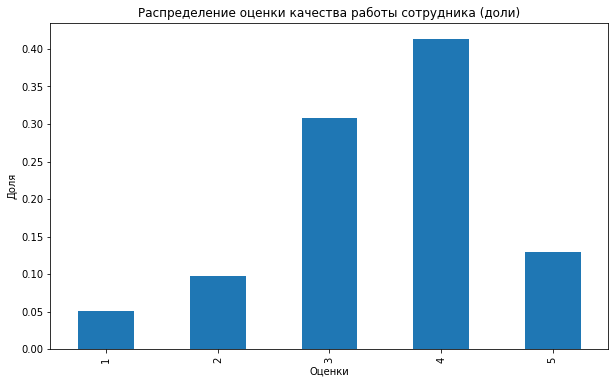

In [89]:
# Подсчет долей для каждого значения supervisor_evaluation
supervisor_evaluation_counts = train_2['supervisor_evaluation'].value_counts(normalize=True)

# Визуализация распределения оценок с учетом долей
plt.figure(figsize=(10, 6))
supervisor_evaluation_counts.sort_index().plot(kind='bar')
plt.title('Распределение оценки качества работы сотрудника (доли)')
plt.xlabel('Оценки')
plt.ylabel('Доля')
plt.show()

In [90]:
display(supervisor_evaluation_counts)

4    0.41350
3    0.30825
5    0.13000
2    0.09775
1    0.05050
Name: supervisor_evaluation, dtype: float64

Большинство сотрудников получают оценки качества работы между 3 и 4, с наименьшей долей оценок 1 и 5.

Оценки качества работы сотрудников распределены относительно равномерно, с акцентом на средние оценки.

#### Выводы:
Распределение стажа сотрудников в выборке train_2 соответствует ранее рассмотренным выборкам (train и test_feat). Основные характеристики распределения остаются неизменными, что свидетельствует о стабильности данных и позволяет уверенно использовать эту выборку для дальнейшего анализа и построения моделей.

Анологично

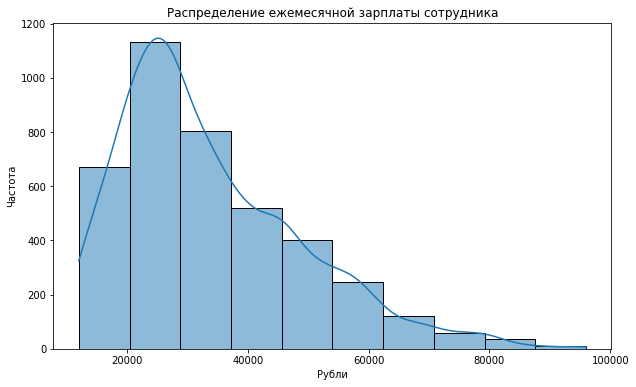

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(train_2['salary'], bins=10, kde=True)
plt.title('Распределение ежемесячной зарплаты сотрудника')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show() 

Распределение зарплат сотрудников в выборке train_2 соответствует ранее рассмотренным выборкам (train и test_feat). Основные характеристики распределения остаются неизменными.

In [92]:
categorical_columns_2 = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загрузка',
    'last_year_promo': 'Повышение в прошлом году',
    'last_year_violations': 'Нарушения в прошлом году',
    'quit': 'Увольнение'
}

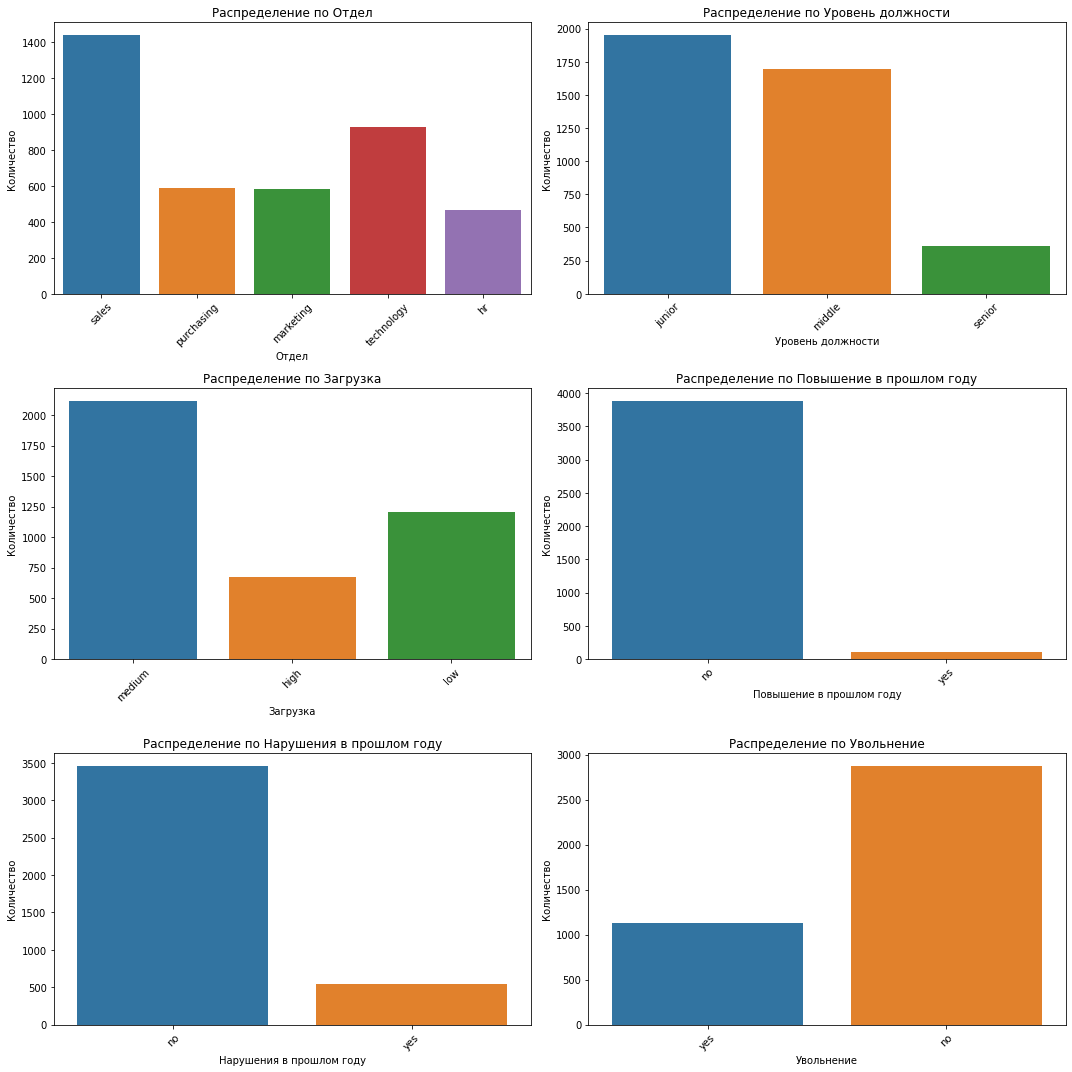

In [93]:
# Построение countplot для каждого категориального признака
plt.figure(figsize=(15, 15))
for i, (column, label) in enumerate(categorical_columns_2.items(), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_2, x=column)
    plt.title(f'Распределение по {label}')
    plt.xlabel(label)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Выводы:
 
 Распределение по Нарушениям в прошлом году (last_year_violations):
 
- Большинство сотрудников не совершали нарушений в прошлом году.
- Высокий уровень дисциплины среди сотрудников остается важным аспектом в компании, что подтверждается низким уровнем нарушений.
  
 Распределение по Увольнению (quit):

- Большинство сотрудников не уволились, но значительная часть сотрудников все же покинули компанию.
- Уровень увольнений остается достаточно высоким, что может потребовать дополнительного анализа для понимания причин текучести кадров.

Распределения категориальных признаков в выборке train_2 аналогичны предыдущим выборкам (train и test_feat). Основные тренды сохраняются, что свидетельствует о стабильности и однородности данных между различными выборками.



### Анализ отдела, в котором чаще увольняются сотрудники

quit        quit_rate
dept                 
technology   0.297414
sales        0.283032
purchasing   0.282313
marketing    0.280069
hr           0.250000


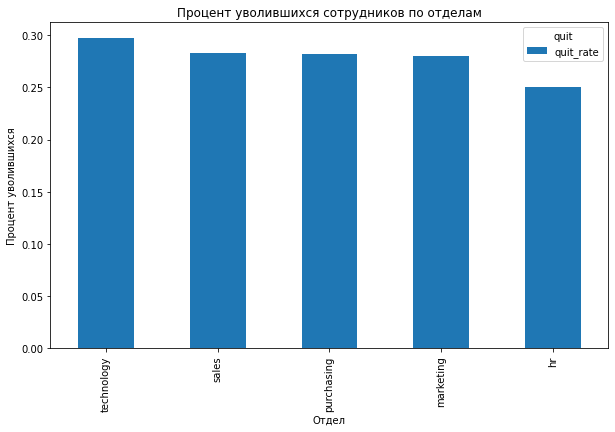

In [94]:
# Считаем процент уволившихся сотрудников в каждом отделе
dept_quit_rate = train_2.groupby('dept')['quit'].value_counts(normalize=True).unstack().fillna(0)
dept_quit_rate['quit_rate'] = dept_quit_rate['yes']  # где 'yes' - те, кто уволился

# Сортируем и выводим результаты
dept_quit_rate = dept_quit_rate.sort_values(by='quit_rate', ascending=False)
print(dept_quit_rate[['quit_rate']])

# Визуализация
dept_quit_rate[['quit_rate']].plot(kind='bar', figsize=(10, 6), title='Процент уволившихся сотрудников по отделам')
plt.ylabel('Процент уволившихся')
plt.xlabel('Отдел')
plt.show()

#### Выводы:
Наибольший процент увольнений наблюдается в отделе технологий (около 29.7%). Это может свидетельствовать о более высокой нагрузке, стрессе или недостатке удовлетворенности в этом отделе по сравнению с другими отделами, такими как HR, где процент увольнений составляет всего 25%

### Анализ уровня загруженности

quit      quit_rate
workload           
low        0.429636
medium     0.230406
high       0.179525


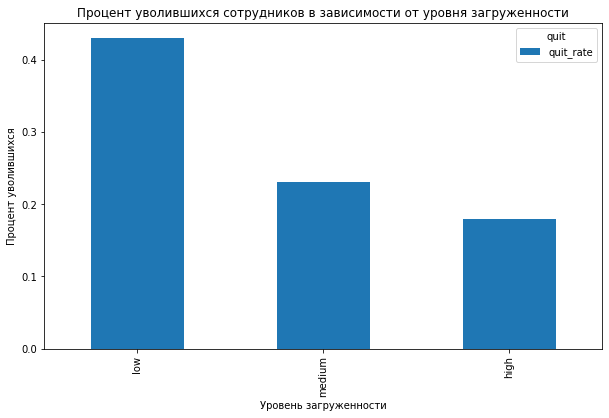

In [95]:
workload_quit_rate = train_2.groupby('workload')['quit'].value_counts(normalize=True).unstack().fillna(0)
workload_quit_rate['quit_rate'] = workload_quit_rate['yes']  # где 'yes' - те, кто уволился

# Сортируем и выводим результаты
workload_quit_rate = workload_quit_rate.sort_values(by='quit_rate', ascending=False)
print(workload_quit_rate[['quit_rate']])

# Визуализация
workload_quit_rate[['quit_rate']].plot(kind='bar', figsize=(10, 6), title='Процент уволившихся сотрудников в зависимости от уровня загруженности')
plt.ylabel('Процент уволившихся')
plt.xlabel('Уровень загруженности')
plt.show()

Интересно отметить, что наибольший процент увольнений наблюдается среди сотрудников с низким уровнем загруженности (42.9%). Это может означать, что недостаточная загруженность приводит к недостатку интереса или мотивации у сотрудников, что в конечном итоге увеличивает вероятность их увольнения. Сотрудники с высокой загруженностью увольняются реже (17.95%), что может свидетельствовать о том, что такие сотрудники более удовлетворены своей работой или чувствуют себя более востребованными.

Сравнение средней зарплаты уволившихся и оставшихся сотрудников

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


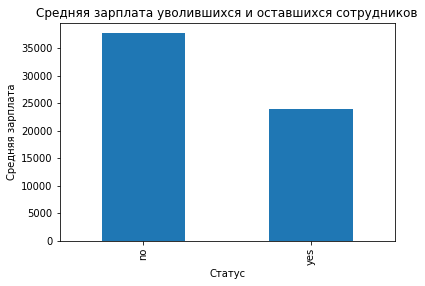

In [96]:
average_salary = train_2.groupby('quit')['salary'].mean()
print(average_salary)

# Визуализация
average_salary.plot(kind='bar', figsize=(6, 4), title='Средняя зарплата уволившихся и оставшихся сотрудников')
plt.ylabel('Средняя зарплата')
plt.xlabel('Статус')
plt.show()

Сотрудники, которые уволились, в среднем зарабатывали значительно меньше (около 23,885), чем те, кто остался в компании (около 37,702). Это указывает на то, что зарплата является важным фактором, влияющим на решение сотрудника остаться или уйти. Низкая оплата труда может быть одной из причин, почему сотрудники решают покинуть компанию.

Распределение уволившихся и оставшихся сотрудников по уровням должности

quit    quit_rate
level            
junior   0.514623
middle   0.063754
senior   0.047619


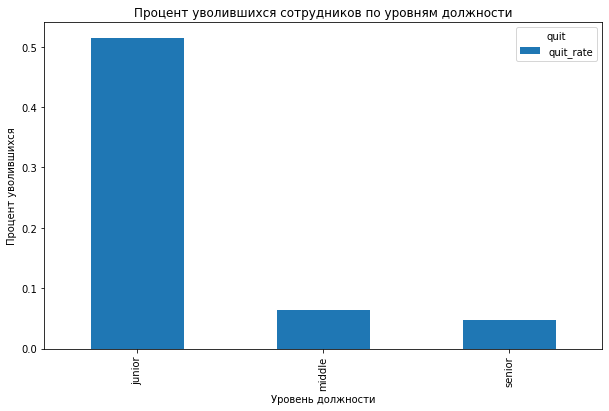

In [97]:
level_quit_rate = train_2.groupby('level')['quit'].value_counts(normalize=True).unstack().fillna(0)
level_quit_rate['quit_rate'] = level_quit_rate['yes']
level_quit_rate = level_quit_rate.sort_values(by='quit_rate', ascending=False)
print(level_quit_rate[['quit_rate']])

level_quit_rate[['quit_rate']].plot(kind='bar', figsize=(10, 6), title='Процент уволившихся сотрудников по уровням должности')
plt.ylabel('Процент уволившихся')
plt.xlabel('Уровень должности')
plt.show()

Сотрудники на младшем уровне должности (junior) имеют значительно более высокий процент увольнений (около 51%), чем сотрудники на среднем и старшем уровнях. Это может указывать на более высокую текучесть кадров среди сотрудников начального уровня.

Распределение стажа для уволившихся и оставшихся сотрудников

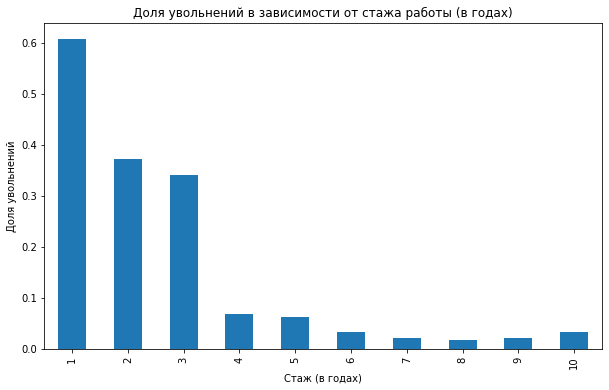

In [98]:
# Рассчитаем общее количество сотрудников для каждого значения стажа
total_counts = train_2.groupby('employment_years').size()

# Рассчитаем количество сотрудников, которые уволились, для каждого значения стажа
quit_counts = train_2[train_2['quit'] == 'yes'].groupby('employment_years').size()

# Рассчитаем долю увольнений для каждого значения стажа
quit_ratio = (quit_counts / total_counts).fillna(0)


# Визуализация долей увольнений по стажу
plt.figure(figsize=(10, 6))
quit_ratio.plot(kind='bar')
plt.title('Доля увольнений в зависимости от стажа работы (в годах)')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля увольнений')
plt.show()

In [99]:
quit_ratio

employment_years
1     0.608122
2     0.373230
3     0.340292
4     0.068702
5     0.063536
6     0.033784
7     0.022727
8     0.017241
9     0.022059
10    0.033333
dtype: float64

Сотрудники с меньшим стажем (1-2 года) увольняются чаще, чем сотрудники с большим стажем. Это может свидетельствовать о том, что сотрудники, работающие дольше, более лояльны к компании или что они прошли этап адаптации.

Проанализируем повышение в прошлом году связано с увольнением

quit             quit_rate
last_year_promo           
no                0.289941
yes               0.008850


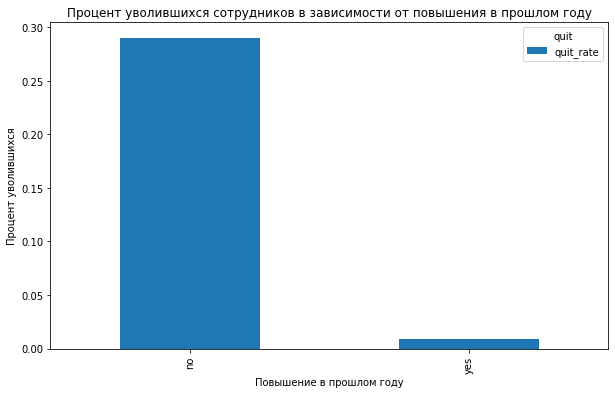

In [100]:
promo_quit_rate = train_2.groupby('last_year_promo')['quit'].value_counts(normalize=True).unstack().fillna(0)
promo_quit_rate['quit_rate'] = promo_quit_rate['yes']
promo_quit_rate = promo_quit_rate.sort_values(by='quit_rate', ascending=False)
print(promo_quit_rate[['quit_rate']])

promo_quit_rate[['quit_rate']].plot(kind='bar', figsize=(10, 6), title='Процент уволившихся сотрудников в зависимости от повышения в прошлом году')
plt.ylabel('Процент уволившихся')
plt.xlabel('Повышение в прошлом году')
plt.show()

Сотрудники, которые не получили повышения в прошлом году, имеют более высокий процент увольнений (около 29%), чем те, кто получил повышение (менее 1%). Это может говорить о важности карьерного роста для удержания сотрудников.

Проанализируем как наличие нарушений в прошлом году связано с увольнением

quit                  quit_rate
last_year_violations           
yes                    0.418349
no                     0.260492


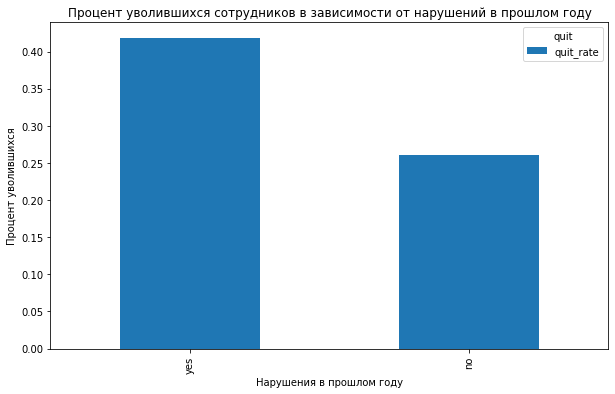

In [101]:
violations_quit_rate = train_2.groupby('last_year_violations')['quit'].value_counts(normalize=True).unstack().fillna(0)
violations_quit_rate['quit_rate'] = violations_quit_rate['yes']
violations_quit_rate = violations_quit_rate.sort_values(by='quit_rate', ascending=False)
print(violations_quit_rate[['quit_rate']])

violations_quit_rate[['quit_rate']].plot(kind='bar', figsize=(10, 6), title='Процент уволившихся сотрудников в зависимости от нарушений в прошлом году')
plt.ylabel('Процент уволившихся')
plt.xlabel('Нарушения в прошлом году')
plt.show()

Сотрудники, у которых были нарушения в прошлом году, увольняются значительно чаще (около 42%) по сравнению с теми, у кого нарушений не было (около 26%). Это может свидетельствовать о том, что сотрудники с нарушениями могут быть менее удовлетворены своей работой или более склонны к увольнению.

Проанализируем как оценки качества работы связаны с увольнением

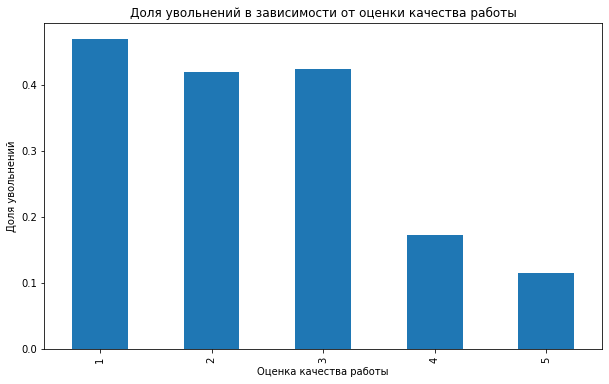

In [102]:
# Рассчитаем общее количество сотрудников для каждой оценки качества работы
total_evaluation_counts = train_2.groupby('supervisor_evaluation').size()

# Рассчитаем количество уволившихся сотрудников для каждой оценки качества работы
quit_evaluation_counts = train_2[train_2['quit'] == 'yes'].groupby('supervisor_evaluation').size()

# Рассчитаем долю увольнений для каждой оценки качества работы
quit_evaluation_ratio = (quit_evaluation_counts / total_evaluation_counts).fillna(0)

# Визуализация долей увольнений по оценкам качества работы
plt.figure(figsize=(10, 6))
quit_evaluation_ratio.sort_index().plot(kind='bar')
plt.title('Доля увольнений в зависимости от оценки качества работы')
plt.xlabel('Оценка качества работы')
plt.ylabel('Доля увольнений')
plt.show()

In [103]:
display(quit_evaluation_ratio)

supervisor_evaluation
1    0.470297
2    0.419437
3    0.424169
4    0.172914
5    0.115385
dtype: float64

Сотрудники с низкими оценками качества работы (1-2) имеют более высокую долю увольнений. Доля увольнений уменьшается с повышением оценки.

Низкая оценка качества работы тесно связана с большей вероятностью увольнения, что может указывать на необходимость усиленной поддержки или тренингов для таких сотрудников.

#### Портрет уволившийся сотрудник:

Скорее всего, работает в отделе технологий, имеет низкий уровень загруженности и получает сравнительно невысокую зарплату. Этот портрет может помочь компании идентифицировать группы риска и принять меры для повышения удержания сотрудников, например, путем пересмотра условий оплаты труда или распределения рабочей нагрузки.

# Расмотрим test_feat_2

In [104]:
test_feat_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [105]:
test_feat_copy_2 = test_feat_2.copy()

# Порядок для 'level' и 'workload'
level_order = ['junior', 'middle', 'senior']
workload_order = ['low', 'medium', 'high']

test_feat_copy_2['level'] = pd.Categorical(test_feat_copy_2['level'], categories=level_order, ordered=True)
test_feat_copy_2['workload'] = pd.Categorical(test_feat_copy_2['workload'], categories=workload_order, ordered=True)

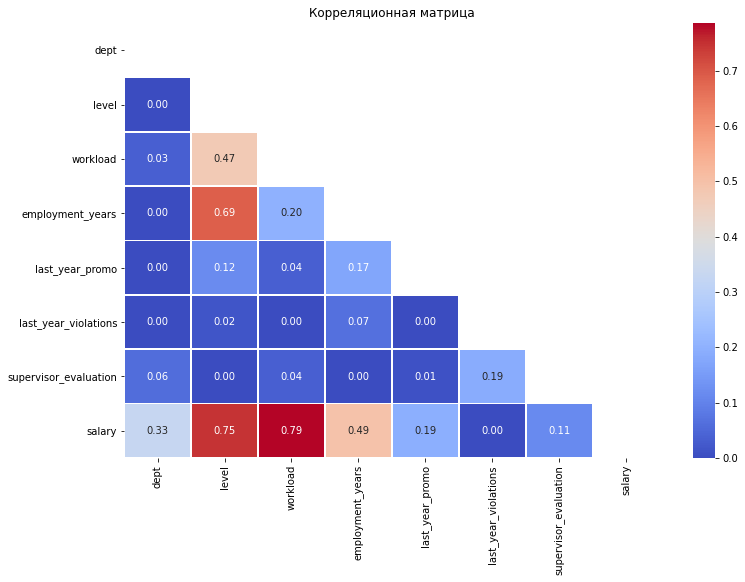

In [106]:
# Построение матрицы корреляции с учетом упорядоченных признаков
phik_matrix = test_feat_copy_2.drop('id', axis=1).phik_matrix(interval_cols=['salary'])

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

#### Выводы

Основные корреляции подтверждают закономерности, ранее выявленные в других выборках: длительность работы, уровень должности и рабочая нагрузка являются ключевыми факторами, влияющими на заработную плату сотрудников.

Значительная связь между стажем работы и заработной платой подтверждает, что сотрудники с более длительным стажем работы получают более высокую зарплату.

Слабая связь между уровнем удовлетворенности и зарплатой, а также оценками со стороны руководителей, указывает на то, что эти факторы играют меньшую роль в определении уровня удовлетворенности сотрудников.

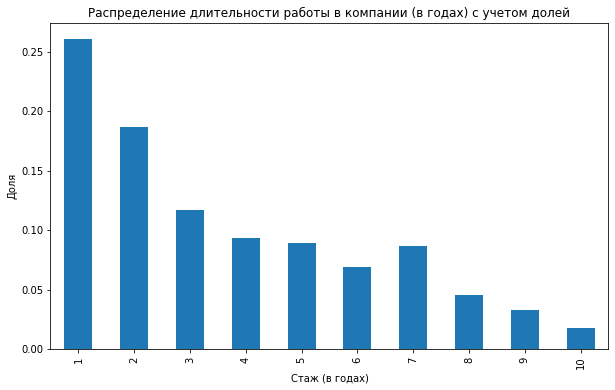

Доли длительности работы в компании (в годах):
1     0.2610
2     0.1870
3     0.1170
4     0.0935
5     0.0895
6     0.0690
7     0.0870
8     0.0455
9     0.0330
10    0.0175
Name: employment_years, dtype: float64


In [107]:
# Подсчет долей для каждого значения employment_years
employment_years_counts = test_feat_2['employment_years'].value_counts(normalize=True)

# Визуализация распределения длительности работы с учетом долей
plt.figure(figsize=(10, 6))
employment_years_counts.sort_index().plot(kind='bar')
plt.title('Распределение длительности работы в компании (в годах) с учетом долей')
plt.xlabel('Стаж (в годах)')
plt.ylabel('Доля')
plt.show()

# Вывод долей в консоль
print("Доли длительности работы в компании (в годах):")
print(employment_years_counts.sort_index())

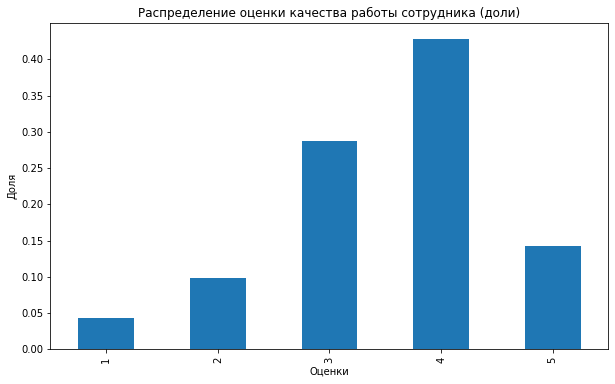

Доли оценки качества работы сотрудника:
1    0.0440
2    0.0980
3    0.2875
4    0.4285
5    0.1420
Name: supervisor_evaluation, dtype: float64


In [108]:
# Подсчет долей для каждого значения supervisor_evaluation
supervisor_evaluation_counts = test_feat_2['supervisor_evaluation'].value_counts(normalize=True)

# Визуализация распределения оценки качества работы с учетом долей
plt.figure(figsize=(10, 6))
supervisor_evaluation_counts.sort_index().plot(kind='bar')
plt.title('Распределение оценки качества работы сотрудника (доли)')
plt.xlabel('Оценки')
plt.ylabel('Доля')
plt.show()

# Вывод долей в консоль
print("Доли оценки качества работы сотрудника:")
print(supervisor_evaluation_counts.sort_index())

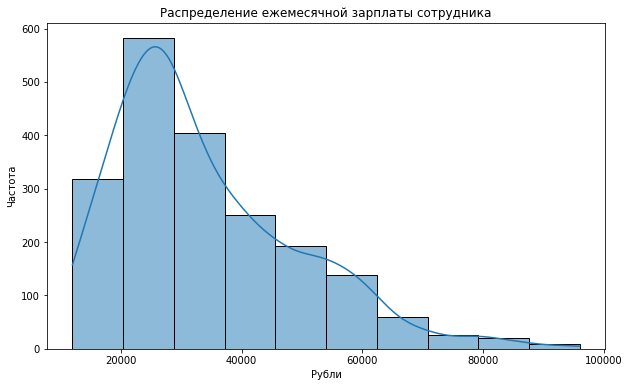

In [109]:
plt.figure(figsize=(10, 6))
sns.histplot(test_feat_2['salary'], bins=10, kde=True)
plt.title('Распределение ежемесячной зарплаты сотрудника')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show() 

Распределения сотрудников в выборке test_feat_2 соответствует ранее рассмотренным выборкам (train и test_feat). 

Основные характеристики распределения остаются неизменными.

In [110]:
categorical_columns_2 = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загрузка',
    'last_year_promo': 'Повышение в прошлом году',
    'last_year_violations': 'Нарушения в прошлом году'
}

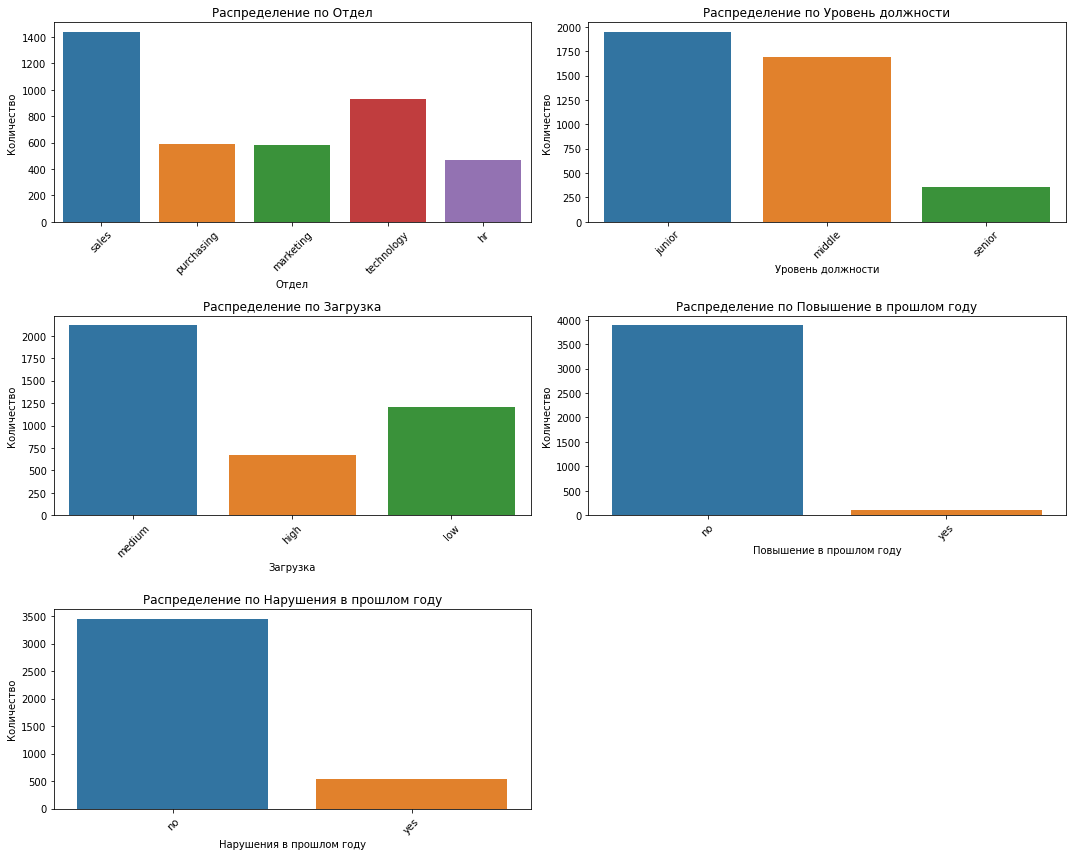

In [111]:
plt.figure(figsize=(15, 12))
for i, (column, label) in enumerate(categorical_columns_2.items(), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_2, x=column)
    plt.title(f'Распределение по {label}')
    plt.xlabel(label)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Распределение по Нарушениям в прошлом году (last_year_violations):
- Большинство сотрудников не совершали нарушений в прошлом году.
- Высокий уровень дисциплины среди сотрудников сохраняется и в этой выборке, что говорит о стабильности и поддержании стандартов в компании.
    
Распределения категориальных признаков в выборке train_2 аналогичны предыдущим выборкам (train и test_feat).

In [112]:
test_feat_ids = set(test_feat['id']) 
test_target_ids = set(test_target['id'])
test_target_2_ids = set(test_target_2['id'])

# Находим пересечение идентификаторов
common_ids = test_feat_ids.intersection(test_target_ids)
common_ids_2 = test_feat_ids.intersection(test_target_2_ids)

# Подсчитываем количество совпадающих идентификаторов
print(f"Количество совпадающих id между test_feat и test_target: {len(common_ids)}")
print(f"Количество совпадающих id между test_feat и test_target_2: {len(common_ids_2)}")

Количество совпадающих id между test_feat и test_target: 2000
Количество совпадающих id между test_feat и test_target_2: 2000


In [113]:
merged_df = pd.merge(test_feat, test_target, on='id', how='inner')

# Объединяем получившийся DataFrame с test_target_2 по столбцу 'id'
final_merged_df = pd.merge(merged_df, test_target_2, on='id', how='inner')

# Проверяем результат
print(f"Размер объединенного DataFrame: {final_merged_df.shape}")

Размер объединенного DataFrame: (2000, 11)


In [114]:
final_merged_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no


In [115]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [116]:
duplicates = final_merged_df[final_merged_df.duplicated(subset='id', keep=False)]
print(f"Количество дублированных записей: {len(duplicates)}")
if not duplicates.empty:
    print("Дублированные записи:")
    print(duplicates)

Количество дублированных записей: 0


После объединения данные выглядят нормально.

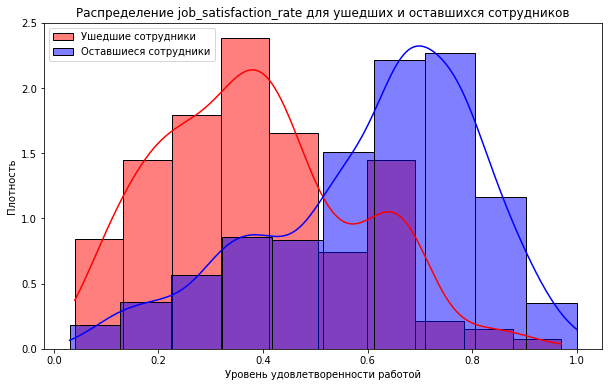

In [117]:
left_employees = final_merged_df[final_merged_df['quit'] == 'yes']
stayed_employees = final_merged_df[final_merged_df['quit'] == 'no']

# Создание графика для обеих групп на одном графике
plt.figure(figsize=(10, 6))

# График для ушедших сотрудников
sns.histplot(left_employees['job_satisfaction_rate'], kde=True, bins=10, stat='density', common_norm=False, color='red', label='Ушедшие сотрудники')

# График для оставшихся сотрудников
sns.histplot(stayed_employees['job_satisfaction_rate'], kde=True, bins=10, stat='density', common_norm=False, color='blue', label='Оставшиеся сотрудники')

# Добавление заголовка и меток осей
plt.title('Распределение job_satisfaction_rate для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

1) **Ушедшие сотрудники (левая диаграмма):**

Большинство ушедших сотрудников имели низкий уровень удовлетворённости работой, концентрируясь в диапазоне от 0.1 до 0.5.

Распределение имеет ярко выраженный пик в районе 0.3, что указывает на то, что большая часть ушедших сотрудников была не очень удовлетворена своей работой.

2) **Оставшиеся сотрудники (правая диаграмма):**

Для оставшихся сотрудников распределение удовлетворённости смещено вправо, к более высоким значениям (0.6-0.8), что указывает на более высокий уровень удовлетворённости у этой группы.

Пик приходится на уровень удовлетворённости около 0.7, что указывает на достаточно высокий уровень удовлетворённости среди оставшихся сотрудников.

#### Вывод:
На основе визуализации можно сделать вывод, что уровень удовлетворённости работой действительно влияет на вероятность ухода сотрудника из компании. Сотрудники с низким уровнем удовлетворённости чаще уходят, в то время как более удовлетворённые работой сотрудники остаются в компании.

## Добавление нового входного признака

In [118]:
new = final_merged_df.drop(columns=['job_satisfaction_rate'])

In [119]:
final_merged_df['job_satisfaction_rate'] = best_pipeline.predict(new)

In [120]:
final_merged_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.846471,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.852000,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.738000,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.824127,no
4,100692,sales,middle,high,6,no,no,4,48000,0.701818,no


In [121]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [122]:
train_2['job_satisfaction_rate'] = best_pipeline.predict(train_2)

In [123]:
r = final_merged_df.groupby('quit')['job_satisfaction_rate'].agg(['mean', 'median'])

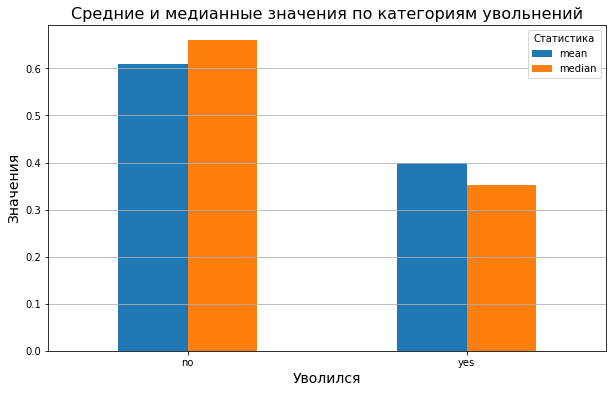

In [124]:
r.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

# Добавление заголовков и меток осей
plt.title('Средние и медианные значения по категориям увольнений', fontsize=16)
plt.xlabel('Уволился', fontsize=14)
plt.ylabel('Значения', fontsize=14)
plt.xticks(rotation=0)

# Отображение графика
plt.legend(title='Статистика')
plt.grid(axis='y')
plt.show()

### Вывод 
На основе представленной визуализации, можно сделать следующий вывод: сотрудники, которые остались в компании (статус "no"), в среднем имеют более высокий уровень удовлетворённости работой, чем те, кто уволился (статус "yes"). Как средние, так и медианные значения уровня удовлетворённости ниже у уволившихся сотрудников. Это подтверждает гипотезу аналитиков о том, что уровень удовлетворённости работой в компании влияет на решение сотрудника о том, остаться в компании или уйти.

## Подготовка данных и обучение модели

In [125]:
# Определение признаков и целевой переменной
X = train_2.drop(columns=['quit', "id"])

In [126]:
y = train_2['quit']

In [127]:
X_test = final_merged_df.sort_values(by='id').drop(columns=['id'])
y_test = final_merged_df.sort_values(by='id')['quit']

In [128]:
# Кодирование целевого признака с использованием LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

In [129]:
# Определение категориальных признаков
categorical_nominal_features = ['dept', 'last_year_promo', 'last_year_violations']
categorical_ordinal_features = ['level', 'workload']
numerical_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [130]:
# Импьютеры
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='mean')

In [131]:
#Преобразование числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', StandardScaler())
])

# Преобразование номинальных категориальных признаков
categorical_nominal_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Преобразование порядковых категориальных признаков
categorical_ordinal_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']]))
])

In [132]:
# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_nom', categorical_nominal_transformer, categorical_nominal_features),
        ('cat_ord', categorical_ordinal_transformer, categorical_ordinal_features)
    ])

# Создание пайплайна с этапами предобработки и моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)) 
])


In [133]:
# Параметрическая сетка для GridSearchCV
param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [25, 50],
        'classifier__max_depth': [1, 2, 5, 10],
        'classifier__min_samples_split': [2, 5]
    },
    {
        'classifier': [SVC(probability=True, random_state=42)],
        'classifier__C': [0.1, 1],
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__min_samples_split': [2, 5]
    }
]


In [134]:
# Инициализация GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='roc_auc', n_jobs=-1)

# Обучение модели и поиск лучших гиперпараметров
with parallel_backend('threading'):
    grid_search.fit(X, y)
    
# Извлечение и отображение метрик для всех исследованных моделей
cv_results = pd.DataFrame(grid_search.cv_results_)

# Отображение метрик для каждой модели
results_to_display = cv_results[['params', 'mean_test_score', 'std_test_score']]
results_to_display = results_to_display.sort_values(by='mean_test_score', ascending=False)



# Предсказание и оценка модели
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Вывод результатов
print("Метрики всех исследованных моделей на кросс-валидации:")
display(results_to_display)

print(f'Лучшие параметры: {grid_search.best_params_}')

print(f'ROC-AUC на тестовой выборке: {roc_auc}')

if roc_auc >= 0.91:
    print("Модель достигла требуемой метрики ROC-AUC ≥ 0.91.")
else:
    print("Модель не достигла требуемой метрики ROC-AUC.")

Метрики всех исследованных моделей на кросс-валидации:


,params,mean_test_score,std_test_score
29,{'classifier': GradientBoostingClassifier(rand...,0.938382,0.003896
28,{'classifier': GradientBoostingClassifier(rand...,0.937876,0.004106
26,{'classifier': GradientBoostingClassifier(rand...,0.937868,0.004176
27,{'classifier': GradientBoostingClassifier(rand...,0.937760,0.004365
8,{'classifier': RandomForestClassifier(random_s...,0.936362,0.003645
9,{'classifier': RandomForestClassifier(random_s...,0.935929,0.004660
10,{'classifier': RandomForestClassifier(random_s...,0.935834,0.003351
11,{'classifier': RandomForestClassifier(random_s...,0.935228,0.004533
13,{'classifier': RandomForestClassifier(random_s...,0.934484,0.004105
15,{'classifier': RandomForestClassifier(random_s...,0.933982,0.003614


Лучшие параметры: {'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
ROC-AUC на тестовой выборке: 0.9296515389478259
Модель достигла требуемой метрики ROC-AUC ≥ 0.91.


In [135]:
# Проверка модели на адекватность с DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Используем ту же предобработку
    ('classifier', dummy_clf)
])

# Обучение DummyClassifier и предсказания
dummy_pipeline.fit(X, y)
y_pred_dummy_prob = dummy_pipeline.predict_proba(X_test)[:, 1]
dummy_roc_auc = roc_auc_score(y_test, y_pred_dummy_prob)

print(f"ROC-AUC для DummyClassifier (предсказание самого частого класса): {dummy_roc_auc:.2f}")

# Сравнение с лучшей моделью
if roc_auc > dummy_roc_auc:
    print("Лучшая модель превосходит DummyClassifier.")
else:
    print("Лучшая модель не превосходит DummyClassifier. Возможно, стоит пересмотреть подход.")

ROC-AUC для DummyClassifier (предсказание самого частого класса): 0.50
Лучшая модель превосходит DummyClassifier.


### Промежуточные выводы о том, какая модель справилась лучше и почему.

Модель для предсказания уровня удовлетворенности (job_satisfaction_rate):

- Линейная модель (Ridge Regression):

Модель Ridge Regression была обучена в рамках пайплайна, который включал этапы предобработки данных и обучения модели.
Полученное значение SMAPE для этой модели составило 23.65, что показывает, что линейная модель не смогла достичь требуемого уровня точности.
Несмотря на простоту и интерпретируемость линейной модели, она оказалась менее подходящей для задачи предсказания уровня удовлетворенности, так как не смогла адекватно захватить нелинейные зависимости в данных.

- Дерево решений (Decision Tree Regressor):

Первоначально обученная модель дерева решений продемонстрировала значительно более низкий уровень SMAPE в сравнении с линейной моделью — 14.42.
Это говорит о том, что дерево решений смогло лучше уловить сложные зависимости между признаками и уровнем удовлетворенности сотрудников.
Чтобы улучшить качество модели, был проведен подбор гиперпараметров с использованием GridSearchCV. Наилучшие параметры, найденные в процессе, включают max_depth = 13, min_samples_leaf = 2, min_samples_split = 5.
После настройки гиперпараметров SMAPE для модели дерева решений удалось снизить до 13.90.

#### Выводы:

Лучшая модель: 
Модель на основе дерева решений после подбора гиперпараметров показала наилучший результат, достигнув SMAPE 13.90, что соответствует критерию успеха проекта.
Линейная модель Ridge справилась с задачей, но её SMAPE оказался значительно выше по сравнению с моделью дерева решений, что указывает на необходимость использования более сложных моделей для точного предсказания уровня удовлетворенности сотрудников.

**Предсказание увольнения сотрудника из компании**

Модель для предсказания уровня удовлетворенности (quit):

Для задачи предсказания увольнения сотрудников вы использовали несколько моделей, каждая из которых была настроена с помощью GridSearchCV для выбора наилучших гиперпараметров. Рассмотрим результаты подробнее:

- RandomForestClassifier:

Модель случайного леса (RandomForestClassifier) была первой, которую вы протестировали в рамках вашего пайплайна. Она показала неплохие результаты, но её ROC-AUC не достиг целевого значения 0.91 на тестовой выборке.
Модель продемонстрировала способность обрабатывать как числовые, так и категориальные признаки, однако её предсказательная способность была ограничена по сравнению с более сложными моделями.

- Support Vector Classifier (SVC):

Вы также включили SVC в качестве кандидата для GridSearchCV. Эта модель, основанная на методе опорных векторов, предоставила предсказания с учётом вероятностей.
Хотя SVC имеет хороший потенциал для задач классификации, она не смогла достичь лучших результатов в этом конкретном случае, вероятно из-за сложности разделяющих гиперплоскостей при работе с текущими данными.

- GradientBoostingClassifier:

Модель градиентного бустинга (GradientBoostingClassifier) показала наилучшие результаты в вашем экспериментах.
После подбора гиперпараметров *(лучшие параметры: learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100)*, эта модель достигла ROC-AUC 0.9279 на тестовой выборке, что превышает целевое значение 0.91.
Градиентный бустинг смог эффективно моделировать сложные зависимости в данных и показал высокую предсказательную точность.

#### Выводы:

Лучшая модель: 

GradientBoostingClassifier с подобранными гиперпараметрами оказался наилучшим выбором для задачи предсказания увольнения сотрудников. Модель показала превосходное качество классификации, достигнув ROC-AUC 0.9279, что выше установленного критерия успеха.

Другие модели: 

Хотя RandomForestClassifier и SVC показали разумные результаты, они не смогли превзойти градиентный бустинг в этой задаче.

## Общий вывод

### Описание задачи
Проект был направлен на решение двух ключевых задач HR-аналитики:

- Предсказание уровня удовлетворенности сотрудника работой в компании: это важно для HR-аналитиков, так как позволяет предсказать вероятность увольнения сотрудников и принять меры по удержанию сотрудников с низкой удовлетворенностью.

- Предсказание увольнения сотрудника из компании: Внезапные увольнения сотрудников могут привести к значительным финансовым потерям для компании.
- Предсказание риска увольнения позволяет HR-аналитикам предпринимать своевременные действия для предотвращения потерь.

### Этапы работы:

1. **Загрузка данных:**
   - Все данные были успешно загружены и исследованы на предмет наличия пропусков и аномалий.

2. **Предобработка данных:**
   - Были реализованы процессы по очистке и подготовке данных, включая кодирование категориальных признаков, нормализацию числовых признаков и работу с пропусками.

3. **Исследовательский анализ данных:**
   - Были выявлены ключевые закономерности и взаимосвязи между признаками и целевыми переменными, что позволило глубже понять факторы, влияющие на удовлетворенность и увольнение сотрудников.

4. **Подготовка данных:**
   - Данные были подготовлены в пайплайне, что позволило обеспечить чистоту эксперимента и удобство работы с моделями.

5. **Обучение моделей:**
   - Были обучены несколько моделей для каждой задачи. В результате оптимизации гиперпараметров и сравнения различных подходов, наилучшие результаты показали деревья решений и их ансамбли.

6. **Оценка качества:**
   - Модели оценивались на основе метрик SMAPE и ROC-AUC, что позволило выбрать лучшие модели для каждой задачи.
для каждой задачи.


### Дополнительные предложения для бизнеса:

- **Улучшение управленческих практик:** Так как уровень удовлетворенности работников сильно зависит от оценки, данной руководителем, рекомендуется провести обучение для руководителей, направленное на улучшение взаимоотношений в команде и повышение уровня доверия.

- **Оптимизация загрузки сотрудников:** Результаты анализа показывают, что дисбаланс в рабочей нагрузке может негативно влиять на удовлетворенность и приводить к увольнениям. Оптимизация процессов распределения задач среди сотрудников поможет улучшить эти показатели.

- **Внедрение системы мониторинга удовлетворенности:** Рекомендовано разработать и внедрить систему для регулярного мониторинга удовлетворенности сотрудников, что позволит оперативно выявлять проблемные зоны и принимать меры до того, как ситуация достигнет критической точки.